In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import os
import acquire
from env import host, user, password

In [2]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

# <font color=“brown”>Goal</font>

**My goal is to predict the values of single unit properties using the obervations from 2017 AKA the column  taxvaluedollarcnt rrenamed into TAXVALUE**

# Acquisition

In [3]:
def get_connection(db, user=user, host=host, password=password):
    '''
    get_connection uses login info from env.py file to access Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

**The columns I need**

bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips, propertylandusetypeid

In [11]:
def get_zillow_data():
    '''
    zillow_data() gets the zillow (only properties_2017 table) data from Codeup db, then writes it to a csv file,
    and returns the df.
    '''
    # Creating a SQL query
    sql_query = '''
                SELECT 
                       bedroomcnt,
                       bathroomcnt,
                       calculatedfinishedsquarefeet,
                       taxvaluedollarcnt,
                       yearbuilt,
                       taxamount,
                       fips,
                       propertylandusetypeid,
                       transactiondate
                FROM properties_2017
                JOIN predictions_2017 USING(parcelid)
                JOIN propertylandusetype USING(propertylandusetypeid)
                WHERE propertylandusetypeid = '261'
                '''
    
    # Reading in the DataFrame from Codeup db.
    properties_2017 = pd.read_sql(sql_query, get_connection('zillow'))
    return properties_2017

In [12]:
def get_local_zillow():
    '''
    get_local_zillow reads in telco data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('properties_2017.csv'):
        
        # If csv file exists read in data from csv file.
        properties_2017 = pd.read_csv('properties_2017.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        properties_2017 = get_zillow_data()
        
        # Cache data
        properties_2017.to_csv('properties_2017.csv')
        
    return properties_2017

In [27]:
# Getting a vue of the dataset

properties_2017 = get_zillow_data()
properties_2017.head(10)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,propertylandusetypeid,transactiondate
0,4.0,3.5,3100.0,1023282.0,1998.0,11013.72,6059.0,261.0,2017-01-01
1,2.0,1.0,1465.0,464000.0,1967.0,5672.48,6111.0,261.0,2017-01-01
2,3.0,2.0,1243.0,564778.0,1962.0,6488.30,6059.0,261.0,2017-01-01
3,4.0,3.0,2376.0,145143.0,1970.0,1777.51,6037.0,261.0,2017-01-01
4,4.0,3.0,2962.0,773303.0,1950.0,9516.26,6037.0,261.0,2017-01-01
5,2.0,1.0,738.0,218552.0,1922.0,2366.08,6037.0,261.0,2017-01-01
6,4.0,3.0,3039.0,220583.0,1970.0,3104.19,6037.0,261.0,2017-01-02
7,4.0,3.0,2540.0,430108.0,1999.0,6103.36,6037.0,261.0,2017-01-02
8,3.0,2.5,1340.0,319668.0,1980.0,4078.08,6059.0,261.0,2017-01-02
9,3.0,2.5,1371.0,198054.0,2004.0,2204.84,6111.0,261.0,2017-01-02


In [14]:
properties_2017.to_csv('/Users/arsen/codeup-data-science/regression_exercises/properties_2017.csv')

# Cleaning

In [15]:
# Looking for comments that could explain the columns

properties_2017.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52442 non-null  float64
 1   bathroomcnt                   52442 non-null  float64
 2   calculatedfinishedsquarefeet  52360 non-null  float64
 3   taxvaluedollarcnt             52441 non-null  float64
 4   yearbuilt                     52326 non-null  float64
 5   taxamount                     52438 non-null  float64
 6   fips                          52442 non-null  float64
 7   propertylandusetypeid         52442 non-null  float64
 8   transactiondate               52442 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


In [16]:
# Amount of nulls per columns

properties_2017.isnull().sum()

bedroomcnt                        0
bathroomcnt                       0
calculatedfinishedsquarefeet     82
taxvaluedollarcnt                 1
yearbuilt                       116
taxamount                         4
fips                              0
propertylandusetypeid             0
transactiondate                   0
dtype: int64

In [17]:
# Getting the proportions of the missing value in the dataset

round(properties_2017.isnull().mean(), 4)

bedroomcnt                      0.0000
bathroomcnt                     0.0000
calculatedfinishedsquarefeet    0.0016
taxvaluedollarcnt               0.0000
yearbuilt                       0.0022
taxamount                       0.0001
fips                            0.0000
propertylandusetypeid           0.0000
transactiondate                 0.0000
dtype: float64

In [18]:
# Printing the columns that have an obscure meaning to look at their content

properties_2017[['taxvaluedollarcnt', 'taxamount', 'calculatedfinishedsquarefeet']]

,taxvaluedollarcnt,taxamount,calculatedfinishedsquarefeet
0,1023282.0,11013.72,3100.0
1,464000.0,5672.48,1465.0
2,564778.0,6488.30,1243.0
3,145143.0,1777.51,2376.0
4,773303.0,9516.26,2962.0
...,...,...,...
52437,354621.0,4478.43,1286.0
52438,67205.0,1107.48,1612.0
52439,49546.0,876.43,1032.0
52440,522000.0,6317.15,1762.0


In [49]:
# Creating a list of the columns to have a better view of it

properties_2017.columns.tolist()

['bedroomcnt',
 'bathroomcnt',
 'calculatedfinishedsquarefeet',
 'taxvaluedollarcnt',
 'yearbuilt',
 'taxamount',
 'fips',
 'propertylandusetypeid',
 'transactiondate']

In [41]:
# Checking the distribution of date and transaction related

properties_2017['transactiondate'].describe()

count          52442
unique           258
top       2017-06-30
freq             810
Name: transactiondate, dtype: object

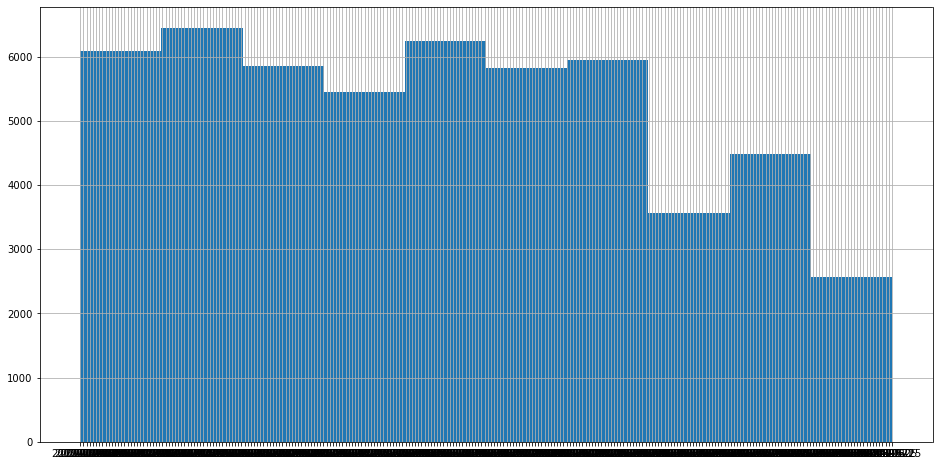

In [38]:
# Plotting a histogram to have a better biew

plt.figure(figsize = (16, 8))

properties_2017['transactiondate'].hist()
plt.grid(True)
plt.show()

## Takeaways

<font color="brown">**Based on the quick look on the data, I need to understand what each column means in order to handle them**</font>

**Description of columns**

This gives a description of the dataset columns according to my understanding through examination of the dataset and online research.

    - bedroomcnt: number of bedrooms
    - bathroomcnt: number of bathrooms
    - calculatedfinishedsquarefeet: size of the property in squarefeet
    - taxvaluedollarcnt: the taxable value of a residential property is 100% of its "market value", basically, what it would sell for on the open market
    - yearbuilt: the year the house was built
    - taxamount: the tax to be paid or paid proportionally to the value of the house
    - fips: Federal Information Processing System (number that uniquely identify geographic areas)
    - Half bathrooms, include toilet and sink; however, unlike full baths, they do not have a bathtub or a shower
    - 6037 in fips is Los Angeles county, CA
    - 6059 in fips is Orange county, CA
    - 6111 in fips is Ventura county, CA

**Cleaning process**
* Drop propertylandusetypeid, it is an identifier and will not affect the processing of the data
* Renamed calculatedfinishedsquarefeet, taxvaluedollarcnt for better readability
* Drop the null values. They account for < 0.004% of the entire dataset. They can be dropped without affecting modeling unless the percentage of rows they represent is too high (~ >= 10%, the table has 52442 entries)
* Convert fips, yearbuilt, taxvalue, indoor_squarefeet, bedroomcnt from float to int64
* There seems to be a lot of outliers as in the case of yearbuilt, calculatedfinishedsquarefeet, and taxvaluedollarcnt for instance. Plotting histograms could help figure out the distribution and outliers

In [44]:
# Dropping null values
houses = properties_2017.dropna(axis = 0, how ='any')

# Providing the proportion of dropped rows
print("Properties_2017 length:", len(properties_2017), "\nHouses length:", 
       len(houses), "\nPercentage of rows with at least 1 NA value dropped: ",
       round(((len(properties_2017)-len(houses))/len(properties_2017))*100, 2))

Properties_2017 length: 52442 
Houses length: 52316 
Percentage of rows with at least 1 NA value dropped:  0.24


In [54]:
# A view of the new dataframe null values

houses.isna().mean()

bedroomcnt                      0.0
bathroomcnt                     0.0
calculatedfinishedsquarefeet    0.0
taxvaluedollarcnt               0.0
yearbuilt                       0.0
taxamount                       0.0
fips                            0.0
propertylandusetypeid           0.0
transactiondate                 0.0
dtype: float64

In [56]:
# Dropping a column

houses = houses.drop(['propertylandusetypeid'], axis = 1)
houses.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,transactiondate
0,4.0,3.5,3100.0,1023282.0,1998.0,11013.72,6059.0,2017-01-01
1,2.0,1.0,1465.0,464000.0,1967.0,5672.48,6111.0,2017-01-01
2,3.0,2.0,1243.0,564778.0,1962.0,6488.30,6059.0,2017-01-01
3,4.0,3.0,2376.0,145143.0,1970.0,1777.51,6037.0,2017-01-01
4,4.0,3.0,2962.0,773303.0,1950.0,9516.26,6037.0,2017-01-01


In [57]:
# Renaming columns using a dictionary

cols_to_rename = {
    'calculatedfinishedsquarefeet': 'indoor_sqft',
    'taxvaluedollarcnt': 'tax_value',
    'transactiondate': 'sale_date',
    'bedroomcnt': 'bedrooms',
    'bathroomcnt': 'bathrooms',
    'taxamount': 'tax_amount',
}

houses = houses.rename(columns=cols_to_rename)
houses.head()

,bedrooms,bathrooms,indoor_sqft,tax_value,yearbuilt,tax_amount,fips,sale_date
0,4.0,3.5,3100.0,1023282.0,1998.0,11013.72,6059.0,2017-01-01
1,2.0,1.0,1465.0,464000.0,1967.0,5672.48,6111.0,2017-01-01
2,3.0,2.0,1243.0,564778.0,1962.0,6488.30,6059.0,2017-01-01
3,4.0,3.0,2376.0,145143.0,1970.0,1777.51,6037.0,2017-01-01
4,4.0,3.0,2962.0,773303.0,1950.0,9516.26,6037.0,2017-01-01


In [58]:
# Checking the values to see if their proportions relate to each other in a meaningful way

houses.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,52316.0,3.305891,0.940592,0.00,3.0000,3.00,4.00,14.0
bathrooms,52316.0,2.302785,1.019072,0.00,2.0000,2.00,3.00,18.0
indoor_sqft,52316.0,1922.537235,1003.626719,128.00,1268.0000,1658.00,2305.00,21929.0
tax_value,52316.0,528039.682506,748451.355979,1000.00,193701.5000,373346.00,618615.00,49061236.0
yearbuilt,52316.0,1963.395634,23.133691,1878.00,1950.0000,1961.00,1979.00,2016.0
tax_amount,52316.0,6434.689275,8709.570842,49.18,2656.2025,4645.15,7371.53,586639.3
fips,52316.0,6049.086092,20.985064,6037.00,6037.0000,6037.00,6059.00,6111.0


In [69]:
# Doing the same as previously but with the sale_date column

houses['sale_date'].describe()

count          52316
unique           258
top       2017-06-30
freq             807
Name: sale_date, dtype: object

In [60]:
# Converting the following columns to int

houses['bedrooms'] = houses['bedrooms'].astype(int)
houses['indoor_sqft'] = houses['indoor_sqft'].astype(int)
houses['tax_value'] = houses['tax_value'].astype(int)
houses['yearbuilt'] = houses['yearbuilt'].astype(int)
houses['fips'] = houses['fips'].astype(int)

houses.head()

,bedrooms,bathrooms,indoor_sqft,tax_value,yearbuilt,tax_amount,fips,sale_date
0,4,3.5,3100,1023282,1998,11013.72,6059,2017-01-01
1,2,1.0,1465,464000,1967,5672.48,6111,2017-01-01
2,3,2.0,1243,564778,1962,6488.30,6059,2017-01-01
3,4,3.0,2376,145143,1970,1777.51,6037,2017-01-01
4,4,3.0,2962,773303,1950,9516.26,6037,2017-01-01


In [61]:
houses.dtypes

bedrooms         int64
bathrooms      float64
indoor_sqft      int64
tax_value        int64
yearbuilt        int64
tax_amount     float64
fips             int64
sale_date       object
dtype: object

In [66]:
for column in houses.columns:
    print(column)
    print(houses[column].value_counts())
    print('\n##########################\n')

bedrooms
3     23347
4     15226
2      8333
5      3970
6       633
1       605
7       106
0        57
8        24
9         8
12        3
10        2
14        1
11        1
Name: bedrooms, dtype: int64

##########################

bathrooms
2.0     21888
3.0     10664
1.0      9552
2.5      3931
4.0      2227
3.5       913
1.5       840
5.0       803
4.5       682
6.0       322
5.5       224
7.0        88
8.0        53
6.5        47
0.0        41
7.5        16
9.0        13
10.0        5
11.0        3
8.5         2
18.0        1
13.0        1
Name: bathrooms, dtype: int64

##########################

indoor_sqft
1120    128
1200    119
1080    102
1040     86
936      86
       ... 
4343      1
4349      1
4825      1
6580      1
5655      1
Name: indoor_sqft, Length: 4720, dtype: int64

##########################

tax_value
455000    34
600000    30
550000    24
500000    24
450000    24
          ..
209341     1
203304     1
497409     1
421945     1
49546      1
Name: tax_value,

bedrooms


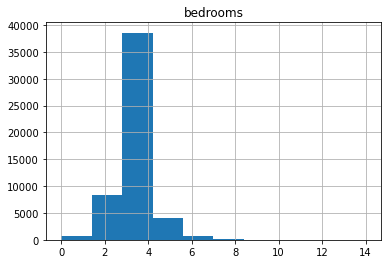

bathrooms


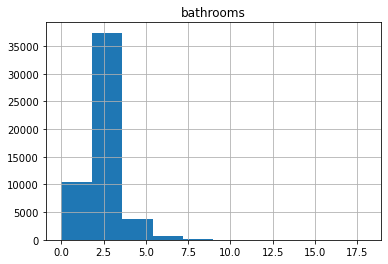

indoor_sqft


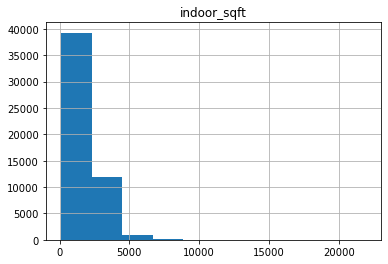

tax_value


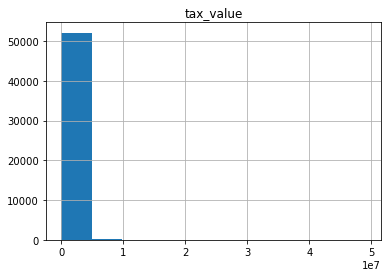

yearbuilt


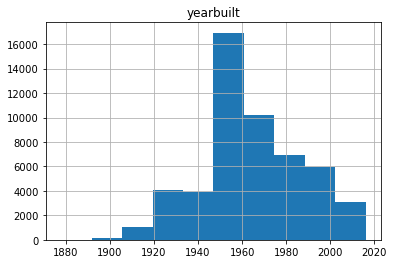

tax_amount


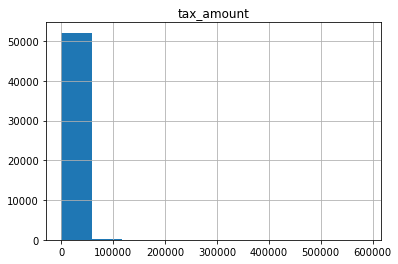

fips


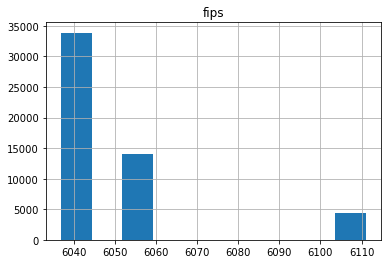

sale_date


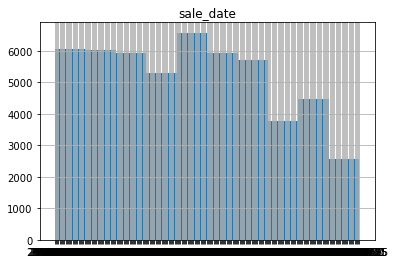

In [65]:
for column in houses.columns:
    print(column)
    plt.title(column)
    houses[column].hist()
    plt.grid(True)
    plt.show()

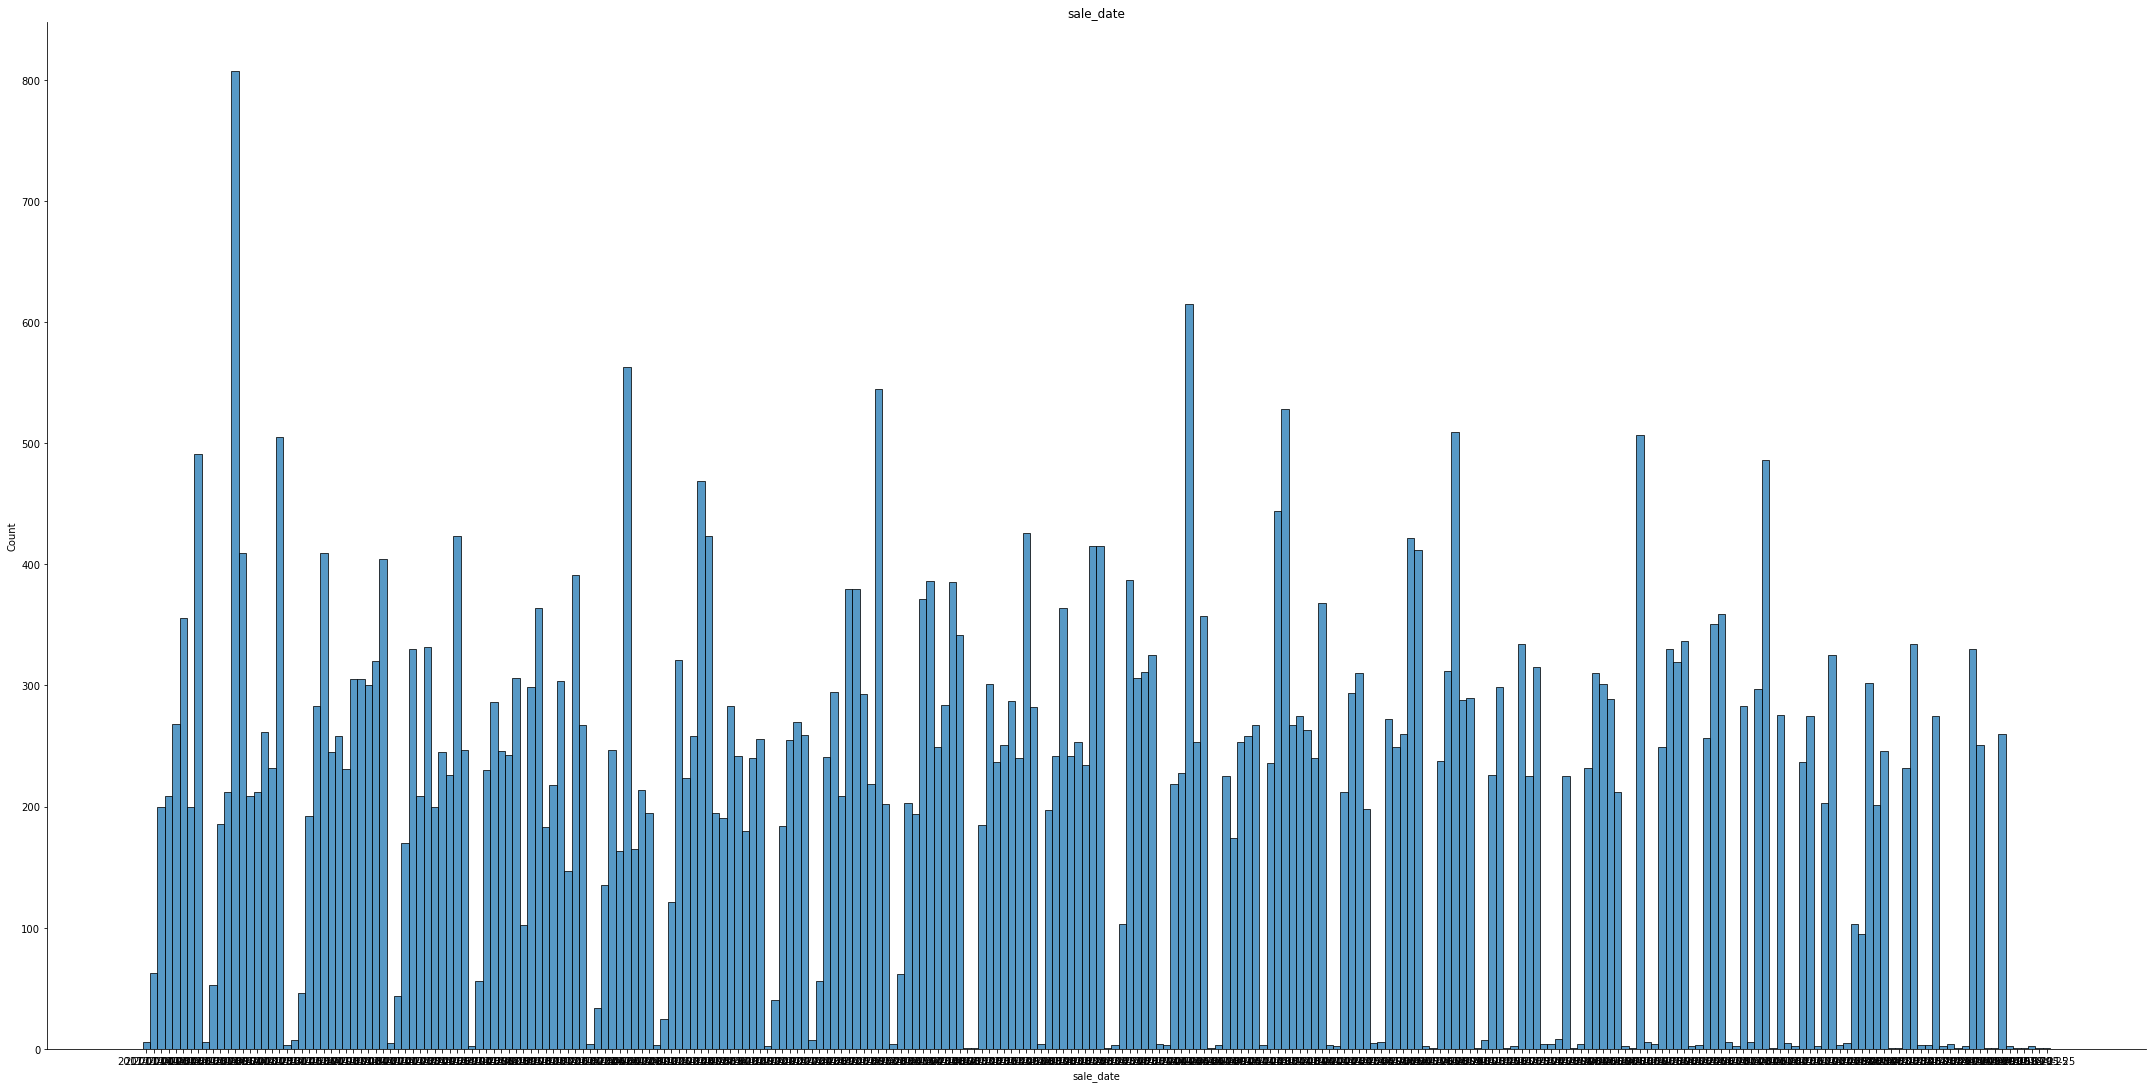

In [103]:
# Plotting more individualized dates

sns.displot(x='sale_date', data=houses, height=15, aspect=2)
plt.title('sale_date')
plt.show()

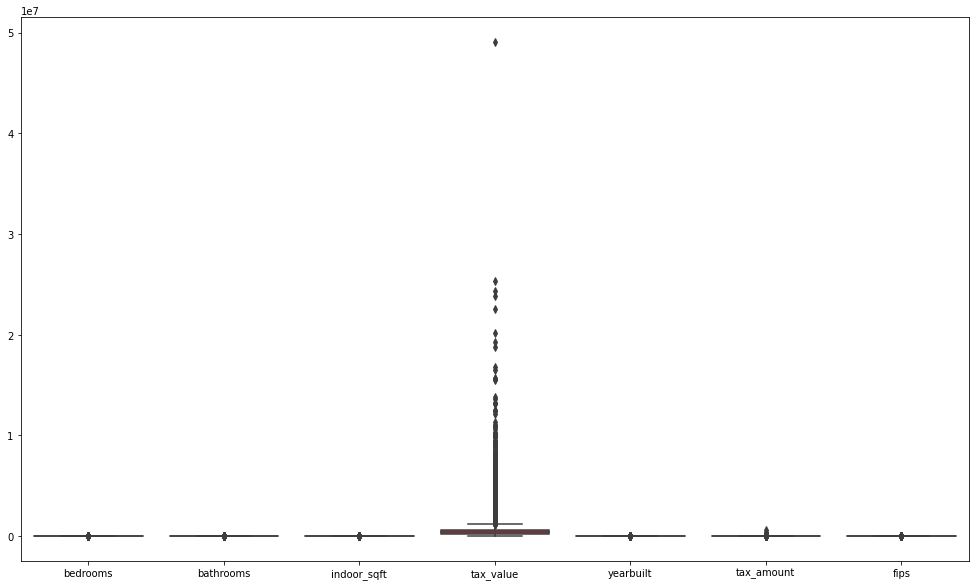

In [109]:
# Create boxplots for all but sale_date

plt.figure(figsize=(17,10))
sns.boxplot(data=houses.drop(columns=['sale_date']))
plt.show()

In [112]:
boxplot_without_tax_value = houses.drop(columns=['tax_value'])
boxplot_without_tax_value.head()

,bedrooms,bathrooms,indoor_sqft,yearbuilt,tax_amount,fips,sale_date
0,4,3.5,3100,1998,11013.72,6059,2017-01-01
1,2,1.0,1465,1967,5672.48,6111,2017-01-01
2,3,2.0,1243,1962,6488.30,6059,2017-01-01
3,4,3.0,2376,1970,1777.51,6037,2017-01-01
4,4,3.0,2962,1950,9516.26,6037,2017-01-01


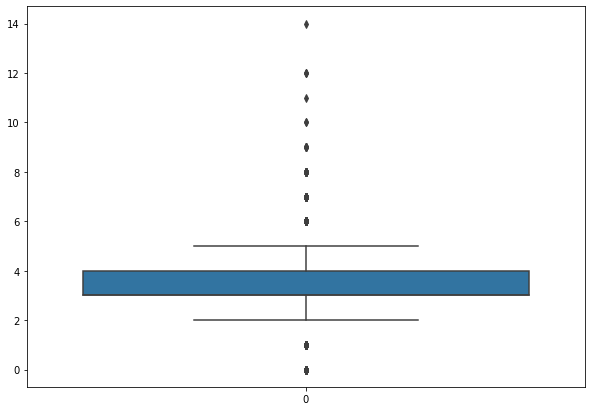

In [122]:
plt.figure(figsize=(10,7))
sns.boxplot(data=houses.bedrooms)
plt.show()

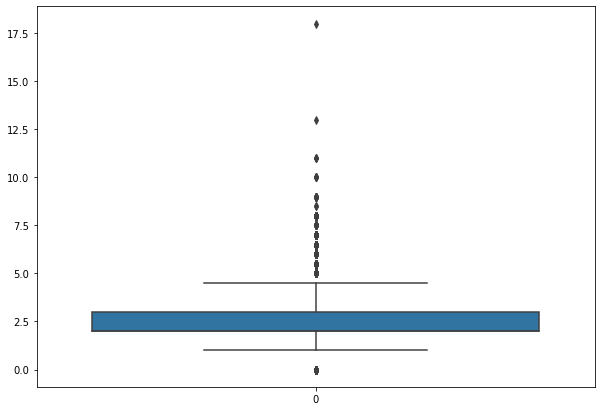

In [123]:
plt.figure(figsize=(10,7))
sns.boxplot(data=houses.bathrooms)
plt.show()

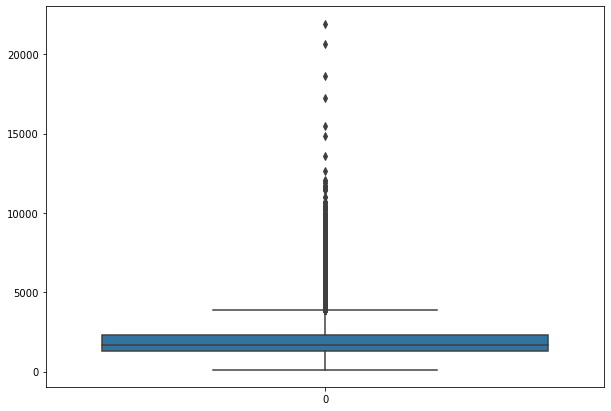

In [124]:
plt.figure(figsize=(10,7))
sns.boxplot(data=houses.indoor_sqft)
plt.show()

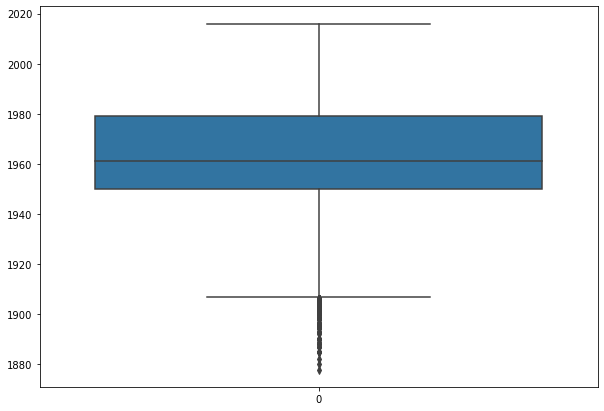

In [125]:
plt.figure(figsize=(10,7))
sns.boxplot(data=houses.yearbuilt)
plt.show()

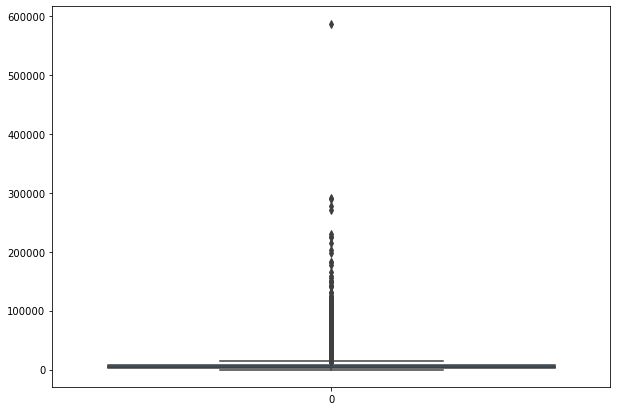

In [126]:
plt.figure(figsize=(10,7))
sns.boxplot(data=houses.tax_amount)
plt.show()

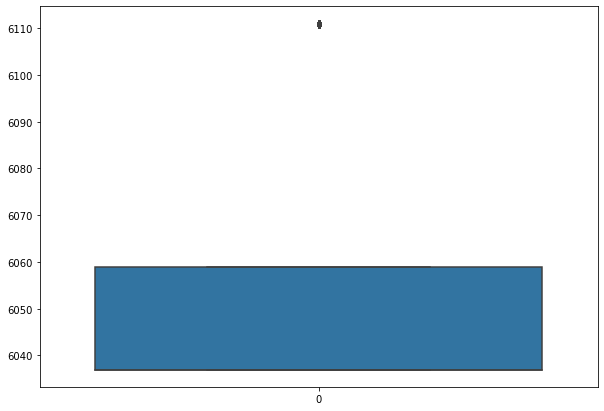

In [127]:
plt.figure(figsize=(10,7))
sns.boxplot(data=houses.fips)
plt.show()

In [64]:
cut_labels = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sept', 'after_sept']
cut_bins = ['2017-1', '2017-2', '2017-3', '2017-4', '2017-5', '2017-6', '2017-7', '2017-8', '2017-9']
houses['sale_date_bins'] = pd.cut(houses['sale_date'], bins=cut_bins, labels=cut_labels)
houses.head(50)

ValueError: could not convert string to float: '2017-1'

## Takeaways
* There are a lot of outliers for tax_value proportionally to the other columns
* Each column contains in itself a lot of outliers
* Yearbuilt and fips can be kept the way they are because their outliers bring more information about the potential price of a house than they disturb the homogeneity of the data (price of a very old house vs that of a new one, difference of price depending on county...)
* 0 bedroom, 0 bathroom, and 1 squarefoot are not too significant (57 and 41 entries but it exist in real estate)
* The tax_value outliers are not a problem because it is the target variable
* After tax_value, tax_amount has the most outliers
* Handle outliers in tax_amount, bedrooms, bathrooms, and indoor_sqft


- My objective is to taget houses that are the closest to the average american house. For that I will:
    * set the limits of bedrooms to 8
    * set the limits of bathrooms to 8
    * set the limit of indoor_sqft to 20_000 sqft
    * set the limit of the tax_amount as a function of sqftage (to what tax_amount corresponds a house with indoor 20_000 sqft?)

In [140]:
# The proportion of houses that have 8 bedrooms and less

houses[houses.bedrooms <= 8].shape[0] / houses.shape[0]

0.9997705150025817

In [144]:
# The proportion of houses that have 8 bathrooms and less

houses[houses.bathrooms <= 7].shape[0] / houses.shape[0]

0.9986804612648448

In [132]:
# The proportion of houses that have 20_000 indoor_squarefeet and less

houses[houses.indoor_sqft <= 20_000].shape[0] / houses.shape[0]

0.9999617707775824

In [134]:
# Mean of tax value of houses corresponding to more than 20_000 sqft

houses[houses.indoor_sqft > 20_000].tax_amount.mean()

175444.95500000002

In [136]:
# The proportion of houses that have tax value <= 18893736

houses[houses.tax_amount <= 175445].shape[0] / houses.shape[0]

0.9997323954430767

## Takeaways
- The proportion obtained are still significant and won't denature the data
- I will filter the data through 7 bathrooms criterion, its most restrictive one 

In [145]:
# Filtering the data through number of bedrooms

houses = houses[houses.bathrooms <= 7]
houses

,bedrooms,bathrooms,indoor_sqft,tax_value,yearbuilt,tax_amount,fips,sale_date
0,4,3.5,3100,1023282,1998,11013.72,6059,2017-01-01
1,2,1.0,1465,464000,1967,5672.48,6111,2017-01-01
2,3,2.0,1243,564778,1962,6488.30,6059,2017-01-01
3,4,3.0,2376,145143,1970,1777.51,6037,2017-01-01
4,4,3.0,2962,773303,1950,9516.26,6037,2017-01-01
...,...,...,...,...,...,...,...,...
52437,2,2.0,1286,354621,1940,4478.43,6037,2017-09-20
52438,4,2.0,1612,67205,1964,1107.48,6111,2017-09-21
52439,3,1.0,1032,49546,1954,876.43,6037,2017-09-21
52440,3,2.0,1762,522000,1955,6317.15,6037,2017-09-25


In [ ]:
# Compiling the code for wrangling data

def get_connection(db, user=user, host=host, password=password):
    '''
    get_connection uses login info from env.py file to access Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'


def get_zillow_data():
    '''
    zillow_data() gets the zillow (only properties_2017 table) data from Codeup db, then writes it to a csv file,
    and returns the df.
    '''
    # Creating a SQL query
    sql_query = '''
                SELECT 
                       bedroomcnt,
                       bathroomcnt,
                       calculatedfinishedsquarefeet,
                       taxvaluedollarcnt,
                       yearbuilt,
                       taxamount,
                       fips,
                       propertylandusetypeid,
                       transactiondate
                FROM properties_2017
                JOIN predictions_2017 USING(parcelid)
                JOIN propertylandusetype USING(propertylandusetypeid)
                WHERE propertylandusetypeid = '261'
                '''
    
    # Reading in the DataFrame from Codeup db.
    properties_2017 = pd.read_sql(sql_query, get_connection('zillow'))
    return properties_2017

def get_local_zillow():
    '''
    get_local_zillow reads in telco data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('properties_2017.csv'):
        
        # If csv file exists read in data from csv file.
        properties_2017 = pd.read_csv('properties_2017.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        properties_2017 = get_zillow_data()
        
        # Cache data
        properties_2017.to_csv('properties_2017.csv')
        
    return properties_2017


# Dropping null values
houses = properties_2017.dropna(axis = 0, how ='any')

# Dropping a column
houses = houses.drop(['propertylandusetypeid'], axis = 1)

# Renaming columns
cols_to_rename = {
    'calculatedfinishedsquarefeet': 'indoor_sqft',
    'taxvaluedollarcnt': 'tax_value',
    'transactiondate': 'sale_date',
    'bedroomcnt': 'bedrooms',
    'bathroomcnt': 'bathrooms',
    'taxamount': 'tax_amount',
}

houses = houses.rename(columns=cols_to_rename)

# Converting the following columns to int
houses['bedrooms'] = houses['bedrooms'].astype(int)
houses['indoor_sqft'] = houses['indoor_sqft'].astype(int)
houses['tax_value'] = houses['tax_value'].astype(int)
houses['yearbuilt'] = houses['yearbuilt'].astype(int)
houses['fips'] = houses['fips'].astype(int)


# Filtering the data through number of bedrooms
houses = houses[houses.bathrooms <= 7]